# Egyptian fruit bats

<img src="https://give.uga.edu/wp-content/uploads/bat-2-e1714165562801.jpg" alt="egyptian fruit bat" width="50%"/>

&copy; University of Georgia

Recordings from:

Prat, Y. et al. (2017). An annotated dataset of Egyptian fruit bat vocalizations across varying contexts and during ontogeny. *Scientific Data*. [https://www.doi.org/10.1038/sdata.2017.143](https://www.doi.org/10.1038/sdata.2017.143)

## Setup

In [1]:
#import packages
import chatter
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
#define config parameters
config = {
    #spectrogram parameters
    'sr': 250000,
    'n_mels': 64,
    'fmin': 1000,
    'fmax': 40000,
    
    #preprocessing parameters
    'high_pass': 1000,
    'low_pass': 40000,
    'threshold': 1.5,

    #pykanto segmentation parameters
    'pykanto_noise_floor': -65,
    'pykanto_top_dB': 65,
    'pykanto_max_dB': -30,
    'pykanto_dB_delta': 5,
    'pykanto_silence_threshold': 0.01,
    'pykanto_min_silence_length': 0.001,
    'pykanto_max_unit_length': 0.2,
    'pykanto_min_unit_length': 0.02,
    'pykanto_gauss_sigma': 10,
    
    #other parameters
    'plot_clip_duration': 5
}
config = chatter.make_config(config)

#initialize the analyzer with the configuration
#using only 8 cores to avoid memory crash during segmentation
analyzer = chatter.Analyzer(config, n_jobs = 8)
model = chatter.Trainer(config)

#set paths
input_dir = Path("/Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/recordings/raw")
processed_dir = Path("/Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/recordings/processed")
h5_path = Path("/Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/spectrograms.h5")
csv_path = Path("/Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/spectrograms.csv")
model_dir = Path("/Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/model")
output_csv_path = Path("/Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/output.csv")

Using 8 cores for parallel processing
Initializing convolutional variational autoencoder
Using device: mps


## Preprocessing

--- Demoing preprocessing for: 130527062206057583.WAV ---
   Segment: 0.00s - 5.00s


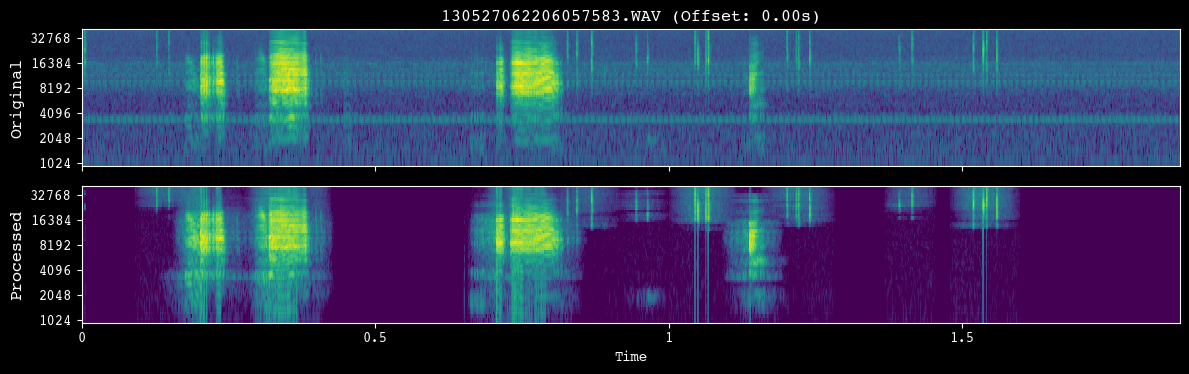

In [22]:
#demo the preprocessing pipeline
analyzer.demo_preprocessing(input_dir)

In [24]:
#preprocess recordings
analyzer.preprocess_directory(input_dir = input_dir, processed_dir = processed_dir)

--- Found 10000 audio files to preprocess ---


Preprocessing audio: 100%|██████████| 10000/10000 [07:28<00:00, 22.30it/s]


--- Preprocessing complete. Standardized WAV audio saved to /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/recordings/processed ---


## Segmentation

--- Demoing segmentation for: 130225053249075024.wav ---
   Segment: 0.00s - 5.00s


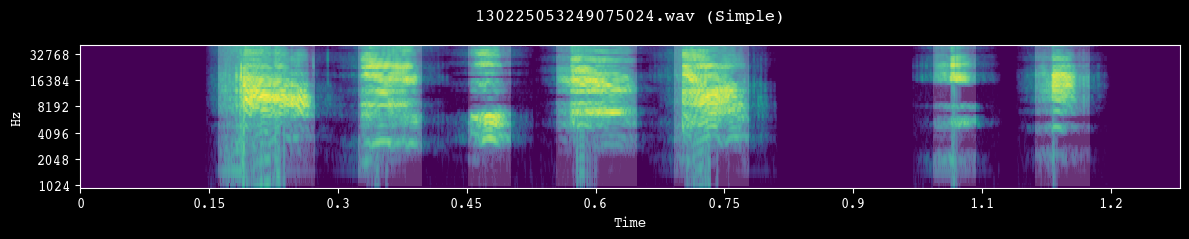

--- Demoing segmentation for: 130219215043723673.wav ---
   Segment: 0.00s - 5.00s


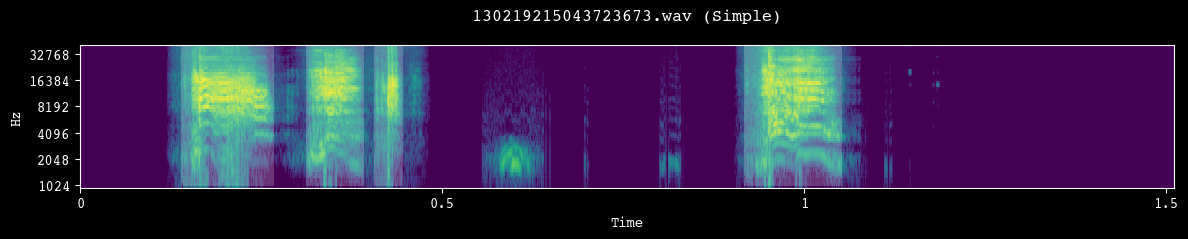

--- Demoing segmentation for: 130302044537445170.wav ---
   Segment: 0.00s - 5.00s


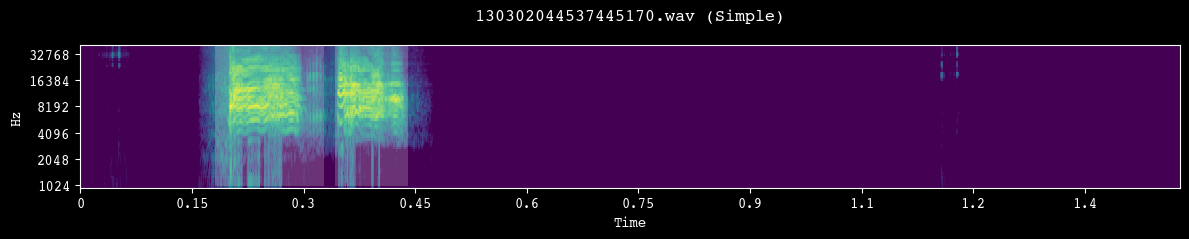

--- Demoing segmentation for: 130228174949622282.wav ---
   Segment: 0.00s - 5.00s


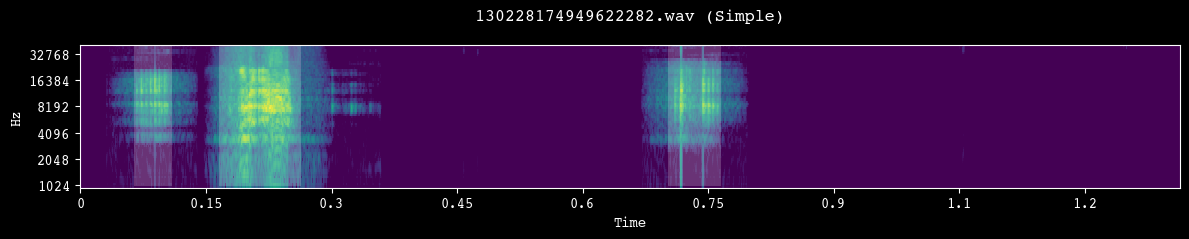

In [13]:
#preview the segmentation pipeline
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)

In [3]:
#segment units and save spectrograms
unit_df = analyzer.segment_and_create_spectrograms(processed_dir = processed_dir, h5_path = h5_path, csv_path = csv_path, simple = False)


--- Found 10000 files to segment using pykanto (image-based) method ---


Segmenting and saving spectrograms: 100%|██████████| 10000/10000 [02:16<00:00, 73.19it/s]




--- Data preparation complete. Created records for 46949 units ---
Spectrograms saved to /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/spectrograms.h5
Unit metadata saved to /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/spectrograms.csv


## Run model

In [14]:
#load segmented units
unit_df = analyzer.load_df(csv_path)

Attempting to load /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/spectrograms.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/spectrograms.csv ---


In [15]:
#train ae
model.train_ae(unit_df = unit_df, h5_path = h5_path, model_dir = model_dir, subset = 0.05)

--- Training on a random subset of 2347 units (5.0%) ---

Starting training for 100 epochs using 4 DataLoader workers...


Training model: 100%|██████████| 100/100 [09:15<00:00,  5.55s/it, loss=1591.1240]


--- Training complete. Model saved to /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/model/model.pth ---
Loss history saved to /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/model/loss.csv


In [17]:
#load trained vae
model = chatter.Trainer.from_trained(config, model_dir)

Instantiating Trainer from pre-trained model at /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/model...
Initializing convolutional variational autoencoder
Using device: mps
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/model/model.pth


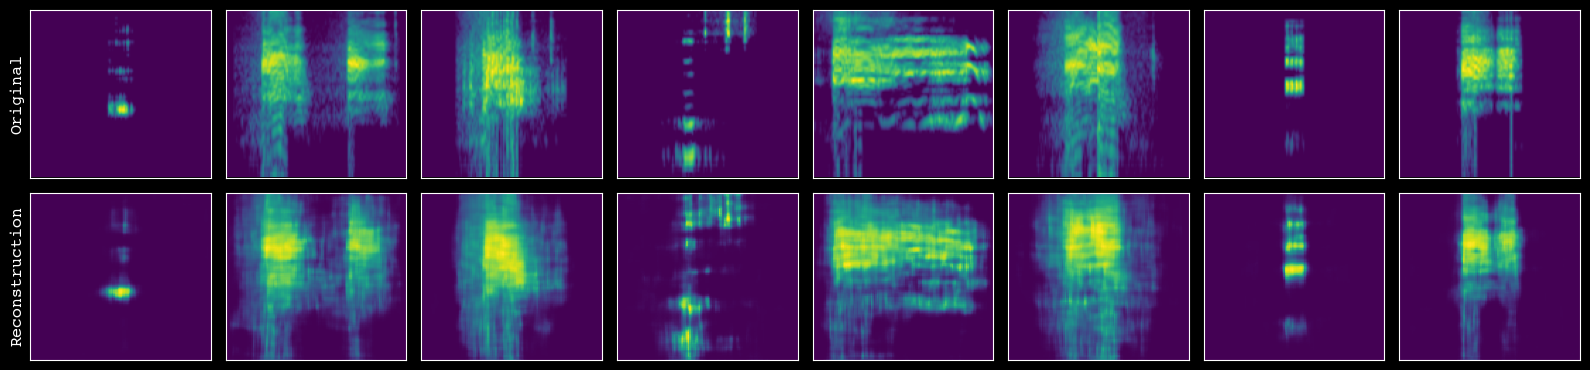

In [18]:
#assess the quality of reconstruction
model.plot_reconstructions(unit_df = unit_df, h5_path = h5_path)

In [20]:
#export the latent features
output = model.extract_and_save_features(unit_df = unit_df, h5_path = h5_path, model_dir = model_dir, output_csv_path = output_csv_path)


--- Starting feature extraction ---
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/model/model.pth


Extracting features: 100%|██████████| 734/734 [00:11<00:00, 63.91it/s] 



--- Pipeline complete. Exported data for 46949 units to /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/output.csv ---


## Postprocessing

In [21]:
#load in latent features
output = chatter.FeatureProcessor(analyzer.load_df(output_csv_path), config)

Attempting to load /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/output.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/egyptian_fruit_bat/output.csv ---


In [22]:
#process output and save
output.run_pacmap()
output.df.to_csv(output_csv_path, index = False)

--- Running PaCMAP dimensionality reduction ---
--- PaCMAP complete ---


--- Automatically selecting focal points from quadrants with seed 111 ---
--- Finding nearest neighbors ---
--- Creating the plot ---
--- Plotting density background (using fast 2d histogram) ---
--- Calculating callout positions and adding spectrograms ---
--- Displaying plot ---


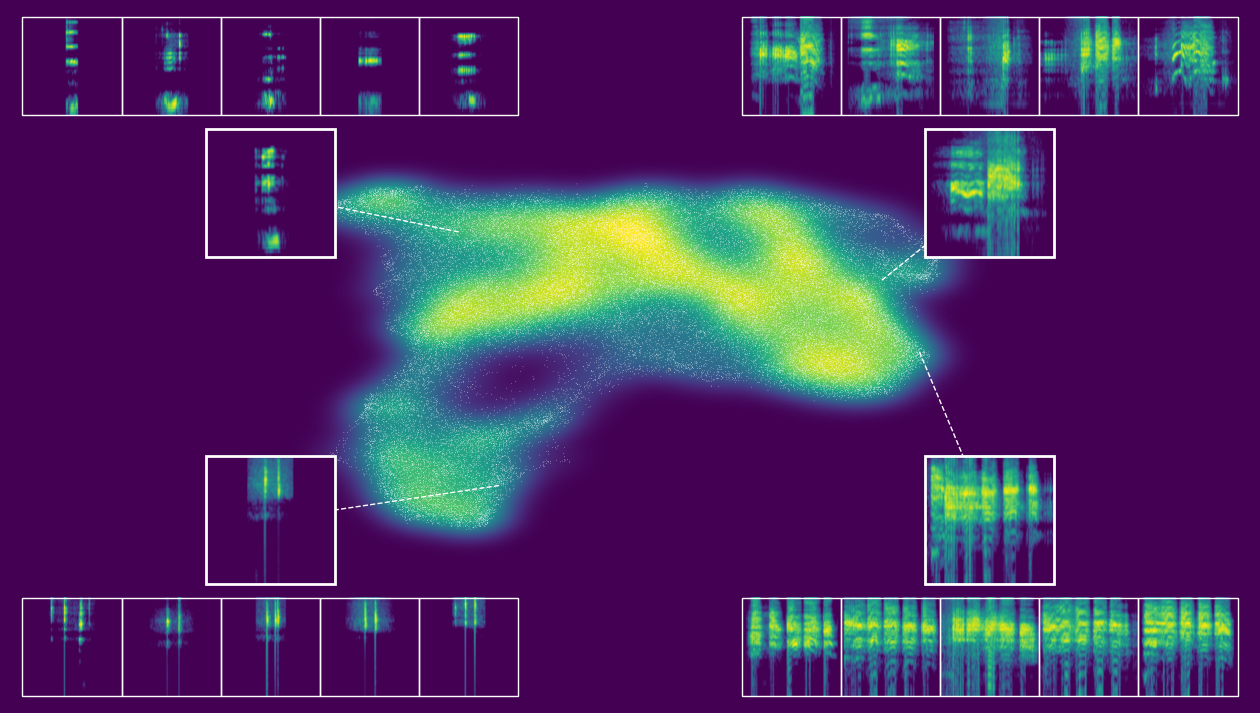

In [28]:
#create interactive or static plot
output.static_embedding_plot(h5_path = h5_path, seed = 111, focal_quantile = 0.6, point_size = 0.2, point_alpha = 1, margin = 0.01, zoom_padding = 0.5, num_neighbors = 5)